<a href="https://colab.research.google.com/github/AntoineDps/Courses/blob/main/Copy_of_cnn_its_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DNA motif discovery using CNN

In this lab, we will use convolutional neural networks (CNN) to detect certain motifs (DNA fragments following specific pattern) in plant DNA sequences downloaded from GenBank.

### Data
The first step is to go to [GenBank](https://https.ncbi.nlm.nih.gov/genbank/) database [FTP service](https://ftp.ncbi.nih.gov/genbank/) and download some data. Whenever researchers sequence DNA coming from an organism and publishe their finding, the DNA sequences are deposited in GeneBank. In their FTP service, one can see a number of `gb***N.seq.gz` files where `***` is an abbreviation for a group of organisms DNA sequences come from, e.g. `bct` for bacteria or `pln` for plants and `N` is a sequence number assigned in a consecutive manner to deposited files. We have downloaded one of such files `gbpln132.seq.gz` and converted it to an easier-to-read format called [FASTA](https://en.wikipedia.org/wiki/FASTA). If you are curious and would like to prepare your own dataset, we used the following `BioPython` file IO routines to convert from GenBank format to FASTA:
```
from Bio import SeqIO
SeqIO.convert("gbpln132.seq", "genbank", "gbpln132.fasta", "fasta")
```

### DNA metabarcoding and amplicon sequencing

Now, let me introduce you to a real research problem. Say, we go to a grocery store and buy a mix of spices. There are some spices listed on a label, but how can we make sure that there actually is basilica in the mix? One of the ways to figure this out is to extract DNA from these dried powdered spices and use it to single out species composition. This part can be somewhat tricky itself as it is not trivial to extract DNA from such mix that possibly also contains some chemicals that may damage the DNA or make extraction very inefficient. Say, however, we have solved this issue, now we can go two ways: 
* sequence all DNA fragments and hope they will say something about the species composition. The risk is, however, that we won't have enough material that is specific to a given species and thus we end up below the detection level.
* try to PCR-amplify (make many copies) of some 'magic' sequence fragments that, we know, are very specific/characteristic to different species. This is called **amplicon sequencing**. 

In this lab, we will go for the second approach. How does it work? Well, first, we need to have some barcodes (special DNA sequence fragments) that are suitable for species identification.

### Properties a DNA barcode

Back to our jar of spices -- we know that, at least in theory, the plants that are on the label should be there, but what else can this jar contain? It can be anything! In fact, any imaginable plant species in the world! So, what we need is a DNA fragment that we know all plants have, so that we can amplify this sequence fragment and we do not risk missing out something. At the same time this should be a **barcode**, i.e. a sequence that is different between all plant species so that we can uniquely identify its source. Sounds like a contradiction? What about a sequence that looks something like this:  

```
cccccccccccccccccUUUUUUUUUUUUUUUUUUCCCCCCCCCCCCCC
```
where `cccccccccc` and `CCCCCCCCCCC` are common for all plants and `UUUUUUUUU` fragment inside is unique for every plant species. What we can do now is to design molecular probes that will fish out `UUUUUUUU` based on it being flanked by `cccc` and `CCCCCC`. 

### ITS1 and ITS2

Quite fortunately for us, such barcodes exist and the two most commonly used types of sequences used for plan identification are called ITS1 and ITS2. They look exactly as we want them to look. Well, with a caveat that sometimes the `UUUUUU` part is similar between some plants but the ITS-es are good enough for many applications. You can read more about ITS-es [here](https://en.wikipedia.org/wiki/Internal_transcribed_spacer).

### Our task
Here, we will see whether we can train CNN to be able to detect short sequence fragments (k-mers) coming from ITS and non-ITS sequences. 

In [ ]:
!pip install biopython
import os
from Bio import SeqIO
import numpy as np
import pandas as pd

# Download example GenBank data
!wget https://www.dropbox.com/s/zjze886uove04s1/gbpln132.fasta

# Read fasta file with sequences
input_file = open('gbpln132.fasta', 'r')

k_mer_size = 100 # we set our k-mer size here
frac_to_take = 0.01 # fraction of sequences to work with due to memeory limits of Colab

seq_lengths = []
its_seq = []
non_its_seq = []

# Below we filter out sequences shorter than k-mer size and the ones 
# that contain Ns (we can change it later). We also populate its1, its2 and non-its
# arrays. 
for sequence in SeqIO.parse(input_file, "fasta") :
  seq_lengths.append(len(sequence.seq))
  if len(sequence.seq) >= k_mer_size:
    if 'ITS' in sequence.description.upper() and 'NN' not in str(sequence.seq.upper()):
        its_seq.append(str(sequence.seq))
    else:
      if 'NN' not in str(sequence.seq.upper): # only remove sequences with more than one N in a consecutive stretch
        non_its_seq.append(str(sequence.seq))
input_file.close()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 7.2 MB/s 
--2022-10-25 09:57:36--  https://www.dropbox.com/s/zjze886uove04s1/gbpln132.fasta
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zjze886uove04s1/gbpln132.fasta [following]
--2022-10-25 09:57:36--  https://www.dropbox.com/s/raw/zjze886uove04s1/gbpln132.fasta
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc149947215586d51ce56e3110ae.dl.dropboxusercontent.com/cd/0/inline/Bvcgbm1iS08K0KK6tn82Qb1vJJAAgRREZC17GYWRImxo8cA3J9h_NXfzRmvYLUi1ED7ny5CRqWgrNLDe-4PKkmMu3UmS58DIVfrNdUXMQRaR575TalPgpJV1tXabTNdpdq9Ne0YsduehcaOCZt9s2iMQ9SWluml5O11KTXIYcVD3Ew/file# [following]
--2022-10-25 09:57

In [ ]:
# we quickly check how many sequences do we have in every class
print(len(its_seq), len(non_its_seq))

5342 19053


In [ ]:

# Randomly select N non-its sequences to match the number of its1+its2 sequences
import random
its_len = len(its_seq)
non_its_seq = random.sample(non_its_seq, its_len)
print("ITS:", len(its_seq))
print("non-ITS:", len(non_its_seq))

ITS: 5342
non-ITS: 5342


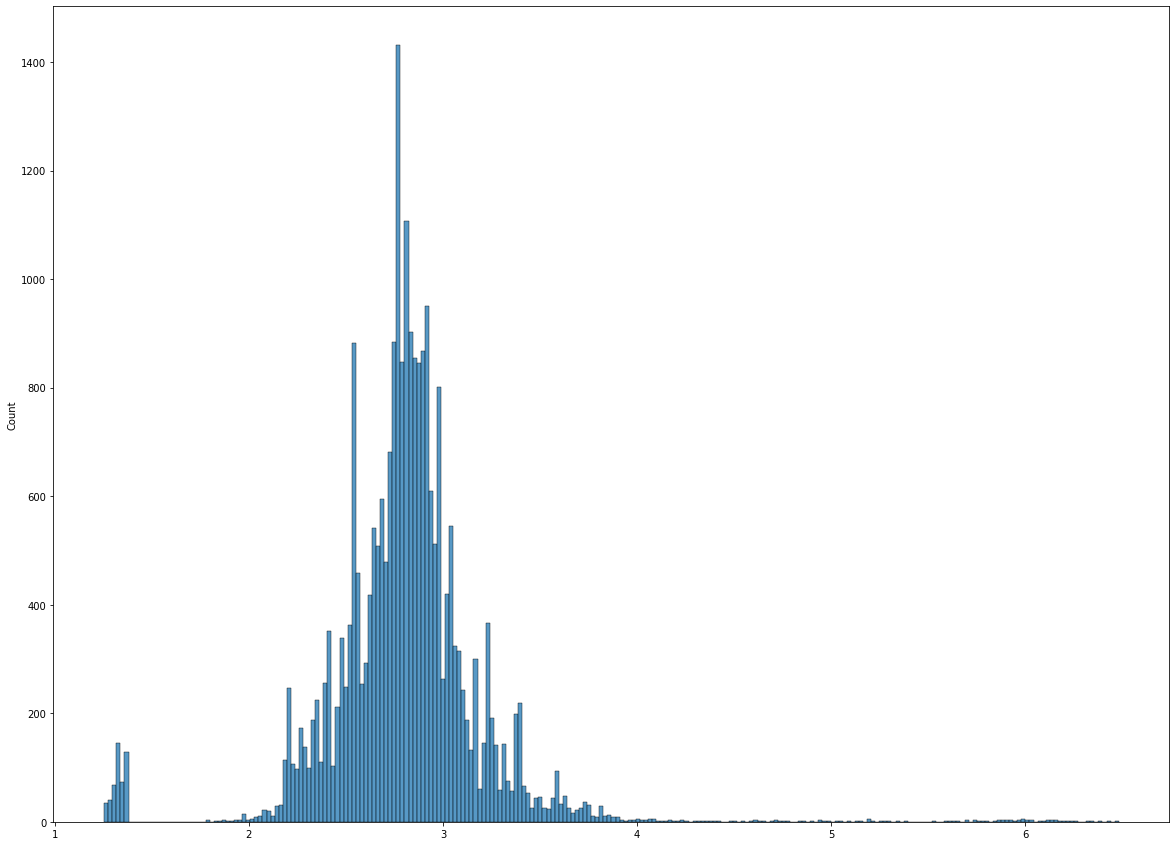

In [ ]:
# Here, we will plot sequence length distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
sns.histplot(data = np.log10(seq_lengths), bins = 250)
plt.show()

In [ ]:
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

# Given a sequence, get all possible k-mers of length l along it.
its = []
non_its = []
for i in its_seq:
  its.extend(getKmers(i, k_mer_size))
  
for i in non_its_seq:
  non_its.extend(getKmers(i, k_mer_size))

In [ ]:
print("Length of ITS:", len(its))
print("Length of non-ITS:", len(non_its))

Length of ITS: 3246108
Length of non-ITS: 38643384


In [ ]:
# Randomly pick up a subset of sequences 
import math
its = random.sample(its, math.floor(len(its) * frac_to_take))
non_its = random.sample(non_its, math.floor(len(non_its) * frac_to_take))
print("Length of ITS:", len(its))
print("Length of non-ITS:", len(non_its))
print("First 2 k-mers in a class:")
print("ITS: ", its[0:2])
print("non-ITS: ", non_its[0:2])

Length of ITS: 32461
Length of non-ITS: 386433
First 2 k-mers in a class:
ITS:  ['TCACGTTGATTACGTCCCTGCCCTTTGTACACACCGCCCGTCGCTACTACCGATTGAATGGCTTAGTGAGACTCTCGGATCGGGTTTTTGGAACCGGCAA', 'CGTGGGAGGGCTTGTCTCGGGCGATAAACCAACCCCCGGCGCGGAACGCGCCAAGGAATATCGTAATGAGATGGCCAGCCGCCAGTGCCCCGTTATTACG']
non-ITS:  ['TTATTTATTTTTTTTTTTTAGAATGAAATTAGGAATGATTATGAAATAGAAAATTCTGAATTTTTTTAGAATTATTGTGAATCCATTTCCTTCGAATATT', 'ATTTCTACTATGTAACTATTGCTATTGTTCTTTTCGATTGCGTATGATTCTATTTCTCTTTGAATAAAAATGTATCGCATTGTTAAAAATACTTGCAACA']


In [ ]:
# Encode bases in our k-mers so that each of the 4 channels corresponds to 
# the probability of each of the four bases.

def encodeSeq(seq):
  dict = {'A':[1,0,0,0],
            'T':[0,1,0,0],
            'C':[0,0,1,0],
            'G':[0,0,0,1],
            'R':[.5,0,0,.5],	         # A or G
            'Y':[0,.5,.5,0],	         # C or T
            'S':[0,0,.5,.5],        	 # G or C
            'W':[.5,.5,0,0],           # A or T
            'K':[0,.5,0,.5],       	   # G or T
            'M':[.5,0,.5,0],	         # A or C
            'B':[0,.33,.33,.33],	     # C or G or T
            'D':[.33,.33,0,.33],	     # A or G or T
            'H':[.33,.33,.33,0],	     # A or C or T
            'V':[.33,0,.33,.33],	     # A or C or G
            'N':[.25,.25,.25,.25]      # A or T or C or G
          }
  seq = list(seq.upper())
  encoded = [dict[base] for base in seq]
  return encoded

encoded_its = list(map(encodeSeq, its))
encoded_non_its = list(map(encodeSeq, non_its))

In [ ]:
print("First 2 encoded k-mers in a class:")
print("Lenghts of encoded ITS: ", len(encoded_its),  ", non-its: ", len(encoded_non_its))
print(encoded_its[0:2])
#print(encoded_its2[0:2])
print(encoded_non_its[0:2])

First 2 encoded k-mers in a class:
Lenghts of encoded ITS:  32461 , non-its:  386433
[[[0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,

In [ ]:
# Here, we will one-hot encode labels
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labels = list(np.ones(len(encoded_its))) + list(np.zeros(len(encoded_non_its)))

# One-hot encode Sequences
#integer_encoder = LabelEncoder()  
one_hot_encoder = OneHotEncoder()  
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()
print('Labels:\n', labels.T) 
print('One-hot encoded labels:\n', input_labels.T)

Labels:
 [[1. 1. 1. ... 0. 0. 0.]]
One-hot encoded labels:
 [[0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]]


In [ ]:
# Prepare the training set
input_features = np.array(encoded_its + encoded_non_its)
print(input_features.shape)
#del(encoded_its)
#del(encoded_non_its)

(418894, 100, 4)


In [ ]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(input_features, input_labels, test_size = 0.25, random_state = 42)
print(train_features[0])
print(train_features.shape)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0.

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.regularizers import l2, l1

tf.compat.v1.disable_eager_execution()

model = Sequential()

model.add(Conv1D(filters = 64, kernel_size = 20, padding = 'same', 
                 kernel_initializer = 'he_uniform', 
                 input_shape=(train_features.shape[1], 4), activation = 'relu',
                 kernel_regularizer=l2(0.001)))
model.add(Conv1D(filters = 32, kernel_size = 10, padding = 'same', 
                 kernel_initializer = 'he_uniform', 
                 activation = 'relu',
                 kernel_regularizer=l2(0.001)))
model.add(MaxPooling1D(pool_size = 2))


model.add(Flatten())
model.add(Dense(16, kernel_initializer= 'he_uniform', activation = 'relu',
                kernel_regularizer=l2(0.001)))
model.add(Dense(2, activation='softmax'))

epochs = 20
lrate = 0.001
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['categorical_accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 100, 64)           5184      
                                                                 
 conv1d_13 (Conv1D)          (None, 100, 32)           20512     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 1600)              0         
                                                                 
 dense_12 (Dense)            (None, 16)                25616     
                                                                 
 dense_13 (Dense)            (None, 2)                 34        
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# Training phase
hp_epochs = epochs
hp_batch_size = 32
hp_val_split = 0.2

cnn_model = model.fit(x = train_features, 
                      y = train_labels,
                      epochs = hp_epochs,
                      batch_size = hp_batch_size,
                      shuffle = True,
                      validation_split = hp_val_split
                      )

Train on 226990 samples, validate on 56748 samples
Epoch 1/20
226990/226990 [==============================] - ETA: 0s - loss: 0.3266 - categorical_accuracy: 0.9505

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


226990/226990 [==============================] - 128s 566us/sample - loss: 0.3266 - categorical_accuracy: 0.9505 - val_loss: 0.3066 - val_categorical_accuracy: 0.9575
Epoch 2/20
226990/226990 [==============================] - 117s 516us/sample - loss: 0.2686 - categorical_accuracy: 0.9620 - val_loss: 0.2500 - val_categorical_accuracy: 0.9641
Epoch 3/20
226990/226990 [==============================] - 118s 518us/sample - loss: 0.2367 - categorical_accuracy: 0.9660 - val_loss: 0.2241 - val_categorical_accuracy: 0.9679
Epoch 4/20
226990/226990 [==============================] - 117s 517us/sample - loss: 0.2148 - categorical_accuracy: 0.9685 - val_loss: 0.2056 - val_categorical_accuracy: 0.9696
Epoch 5/20
226990/226990 [==============================] - 117s 514us/sample - loss: 0.1988 - categorical_accuracy: 0.9703 - val_loss: 0.1924 - val_categorical_accuracy: 0.9707
Epoch 6/20
226990/226990 [==============================] - 120s 527us/sample - loss: 0.1861 - categorical_accuracy: 0.97

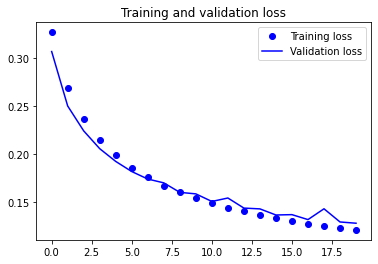

In [ ]:
#model.save_weights('its_cnn_weights.h5', overwrite = True)
from google.colab import drive
import keras

#drive.mount('/content/drive')
#model.save('/content/drive/its_cnn_model.h5')
#model = keras.models.load_model('its_cnn_model.h5')
loss = cnn_model.history['loss']
val_loss = cnn_model.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Confusion matrix:
 [[85567   915]
 [ 1124  6974]]


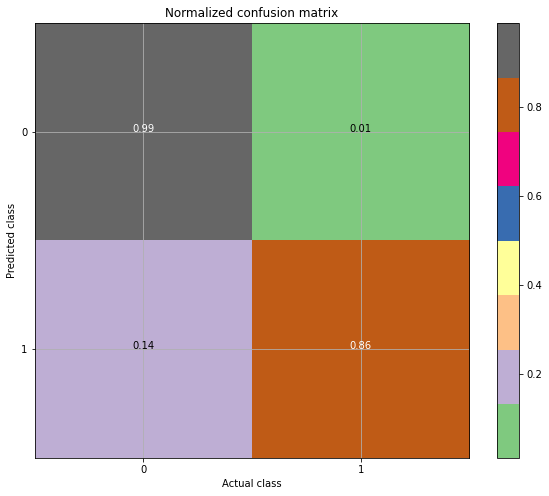

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(10,8))

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Accent)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('Actual class')
plt.ylabel('Predicted class')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()


In [ ]:
scores = model.evaluate(test_features, test_labels, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 97.84%


In [ ]:
import keras.backend as K

def compute_salient_bases(model, x):
    input_tensors = [model.input]
    gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
    compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
    
    x_value = np.expand_dims(x, axis=0)
    gradients = compute_gradients([x_value])[0][0]
    sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)
    return sal

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


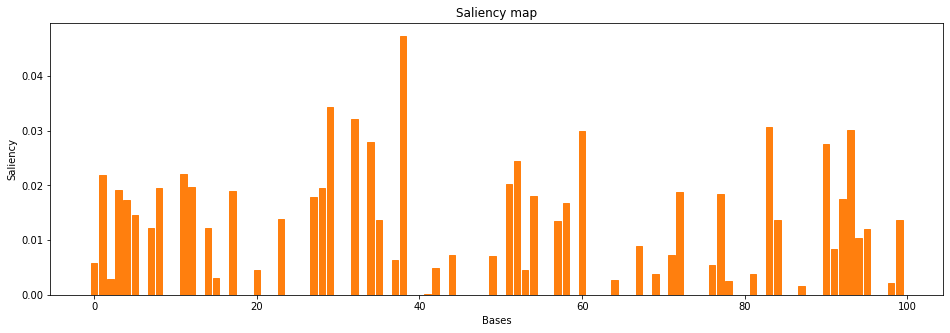

In [ ]:
K.set_learning_phase(1) #set learning phase
sals = []
for sequence_index in range(0,10):
  sals.append(compute_salient_bases(model, input_features[sequence_index]))

sal = sals[0]
#print(sals)

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C1') for i in range(0,len(sal))]
plt.xlabel('Bases')
plt.ylabel('Saliency')
plt.title('Saliency map');
plt.show()